# Trajectory Plots
The purpose of this notebook is to plot training (manual) and trial (autonomus) lap data for analysis and presentation.  

Plots:
* Manual lap trajectory
* Autonomous lap trajectory
* Autonomous laps trajectories overlaid with training lap trajectory
* Manual lap trajectory with each point color-scaled by speed
* Autonomous lap trajectory with each point color-scaled by speed
* Manual lap trajectory with each point color-scaled by throttle
* Autonomous lap trajectory with each point color-scaled by throttle


In [1]:
## Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageOps

## Data
### Constants/Parameters

In [2]:
#               0      1     2     3      4    5     6      7     8
MODEL_IDS =    [131,  141,  143,   157,  166,  170,  172,   176,  178]
SCALE_FACTOR = [6.02, 6.0, 6.0,    6.0,  6.,   6.0, 6.0,  6.01,    6]
X_SHIFT =      [18,   21,   24,    19,   25,   15,   44,    17,   30]
Y_SHIFT =      [28,   31,   40,    15,   13,   20,   13,    23,   12]
n_models = len(MODEL_IDS)
TRACK_HEIGHT = 820
TRACK_WIDTH = 965
TRAIN_SCALE_FACTOR = 6.0
TRAIN_X_SHIFT = 19
TRAIN_Y_SHIFT = 21

# Track image
img_file = '../assets/images/simple_barriers.png'

### Load Manual Data

In [3]:
df_train = pd.read_csv('../data/11_12_2021/19_28_18/fast_laps.csv')
df_train.head()

,Unnamed: 0,steering,throttle,speed,image,hit,time,accel_x,accel_y,accel_z,...,pos_x,pos_y,pos_z,vel_x,vel_y,vel_z,on_road,progress_on_shortest_path,lap,lap_time
0,926,0.0,1.0,15.45082,48.93143.PNG,none,48.93143,-3.056049,1.045692,-2.689648,...,12.28500,0.564311,-71.73002,0.192728,-0.480838,15.44213,0,0,2,42.056042
1,927,0.0,1.0,15.59336,48.98182.PNG,none,48.98182,-0.326562,-0.933254,4.651165,...,11.68473,0.565590,-72.44434,0.122449,-0.500054,15.58486,0,0,2,42.056042
2,928,0.0,1.0,15.63613,49.03141.PNG,none,49.03141,-0.194716,-0.846916,4.212666,...,11.28343,0.566273,-72.92320,0.072428,-0.499339,15.62798,0,0,2,42.056042
3,929,0.0,1.0,15.65197,49.08226.PNG,none,49.08226,-1.538253,0.598228,-1.312637,...,10.67941,0.566933,-73.64472,0.002094,-0.488114,15.64436,0,0,2,42.056042
4,930,0.0,1.0,15.70087,49.13142.PNG,none,49.13142,-1.226282,0.470649,-0.997162,...,10.27552,0.567166,-74.12733,-0.021720,-0.493240,15.69311,0,0,2,42.056042


### Load Autonomous Data

In [4]:
trial_frames = [pd.read_pickle(f'../data/trials/model_{model}_trials.pkl') for model in MODEL_IDS]
df_trial = pd.concat(trial_frames)
df_trial.head()

,steering_angle,throttle,speed,activeNode,pos_x,pos_z,lap
32,-0.063112,0.991849,3.999948,2,11.78176,-70.71587,1
33,-0.063112,0.991849,4.092230,2,11.67610,-70.84211,1
34,-0.062444,0.992457,4.229958,2,11.51380,-71.03723,1
35,-0.058957,0.992451,4.321350,2,11.40308,-71.17116,1
36,-0.054217,0.992313,4.457781,2,11.23328,-71.37778,1


## Helper Methods

In [5]:
# The image of the track over which I am plotting the trajectory data
# is a different scale than the data itself. The data is also offset
# heavily in the negative direction. This function resets that and 
# scales the trajectory properly. The scale factor and shifts were tuned
# by hand and are slightly inaccurate.
def get_x_y(i=None, train=False):
    if train:
        lap_df = df_train
        scale_factor = TRAIN_SCALE_FACTOR
        x_shift = TRAIN_X_SHIFT
        y_shift = TRAIN_Y_SHIFT
    else:
        lap_pkl = f'../data/trials/model_{MODEL_IDS[i]}_trials.pkl'
        lap_df = pd.read_pickle(lap_pkl)
        scale_factor = SCALE_FACTOR[i]
        x_shift = X_SHIFT[i]
        y_shift = Y_SHIFT[i]
    lap_df['shift_x'] = lap_df['pos_x'] - lap_df['pos_x'].min()
    lap_df['shift_z'] = lap_df['pos_z'] - lap_df['pos_z'].min()
    lap_df['scaled_x'] = lap_df['shift_x'] * scale_factor
    lap_df['scaled_z'] = lap_df['shift_z'] * scale_factor
    x = lap_df['scaled_x'] + x_shift
    y = lap_df['scaled_z'] + y_shift
    return x, y

# This function collects all autonomous lap tractory data, scaled
# and shifted appropriately for each model, and returns it for use
# as plot inputs.
def get_trial_laps():
    trial_frames = []
    for i in range(n_models):
        lap_pkl = f'../data/trials/model_{MODEL_IDS[i]}_trials.pkl'
        df = pd.read_pickle(lap_pkl)
        df['shift_x'] = df['pos_x'] - df['pos_x'].min()
        df['shift_z'] = df['pos_z'] - df['pos_z'].min()
        df['scaled_x'] = (df['shift_x'] * SCALE_FACTOR[i]) + X_SHIFT[i]
        df['scaled_z'] = (df['shift_z'] * SCALE_FACTOR[i]) + Y_SHIFT[i]
        df.reset_index(drop=True)
        trial_frames.append(df.copy())
    return pd.concat(trial_frames)

# This is a simple helper function for the plain trajectory plots.
def plot_track(x, y, ax, title=None, color='hotpink', img=None, alpha=1.0):
    ax.axis('off')
    ax.set_aspect('equal')
    if title:
        plt.title(title, size=20)
    if img:
        img = img.transpose(method=Image.FLIP_TOP_BOTTOM)
        ax.imshow(img)
        ax.invert_yaxis()
    ax.plot(x, y, linewidth=1, color=color, alpha=alpha);

## Plots

### Manual Lap Trajectories

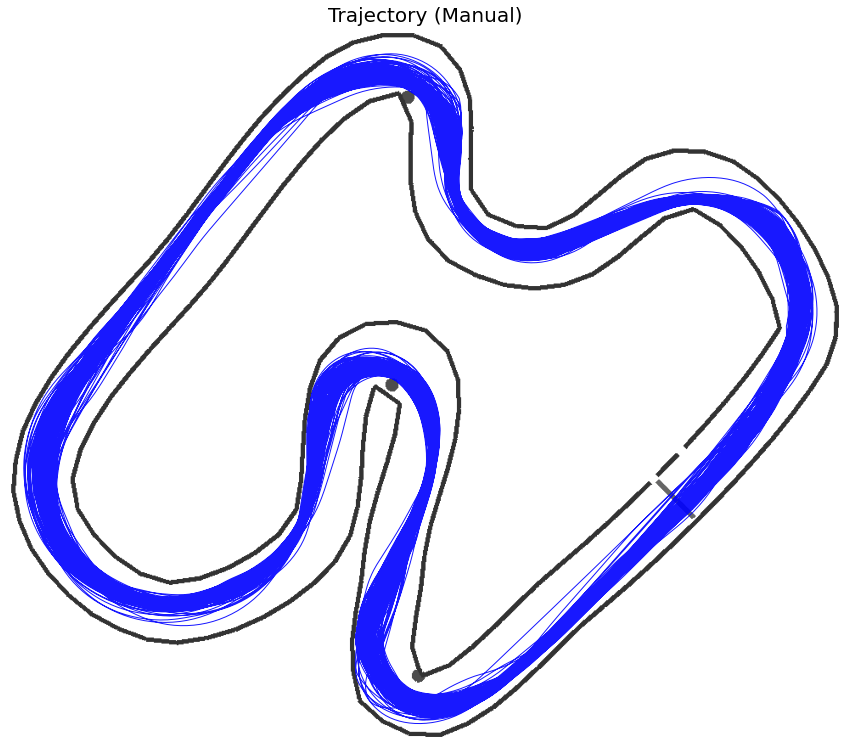

In [6]:
x1, y1 = get_x_y(df_train, train=True)
fig, ax = plt.subplots(figsize=(15,15))
img = Image.open(img_file).copy()
plot_track(x1, y1, ax, title='Trajectory (Manual)', color='blue', img=img, alpha=0.9)

*Analysis*:
* I could have been more consistent with the line I took, but I imagine this is sufficient.

### Autonomous Lap Trajectories

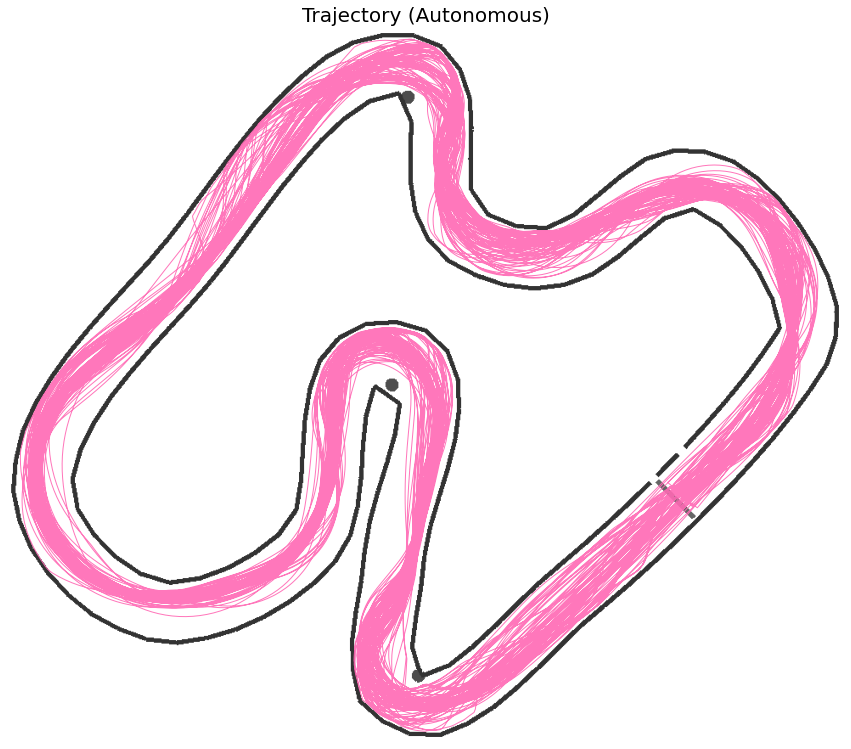

In [7]:
x1, y1 = get_x_y(df_train, train=True)
df = get_trial_laps()
x2 = df['scaled_x']
y2 = df['scaled_z']
img = Image.open(img_file).copy()
img = img.transpose(method=Image.FLIP_TOP_BOTTOM)
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(img)
ax.invert_yaxis()
plt.title('Trajectory, All Autonomous Laps', size=25)
plot_track(x2, y2, ax, title='Trajectory (Autonomous)', color='hotpink', alpha=0.9)

*Analysis*:
* These plots highlight an interesting emergent behavior. Given that the models seemed to crash into every wall, successful completion of laps depended on angle of impact but also, as demostrated in the long straight just before the turn at the very top, strategic collisions. Hitting the wall on the straight scrubbed enough speed to better negotiate the upcoming turn. This is clearly maladaptive when viewed in the context of actual race cars, but it is a neat curiousity here.

### Combined Autonomous/Manual Trajectories

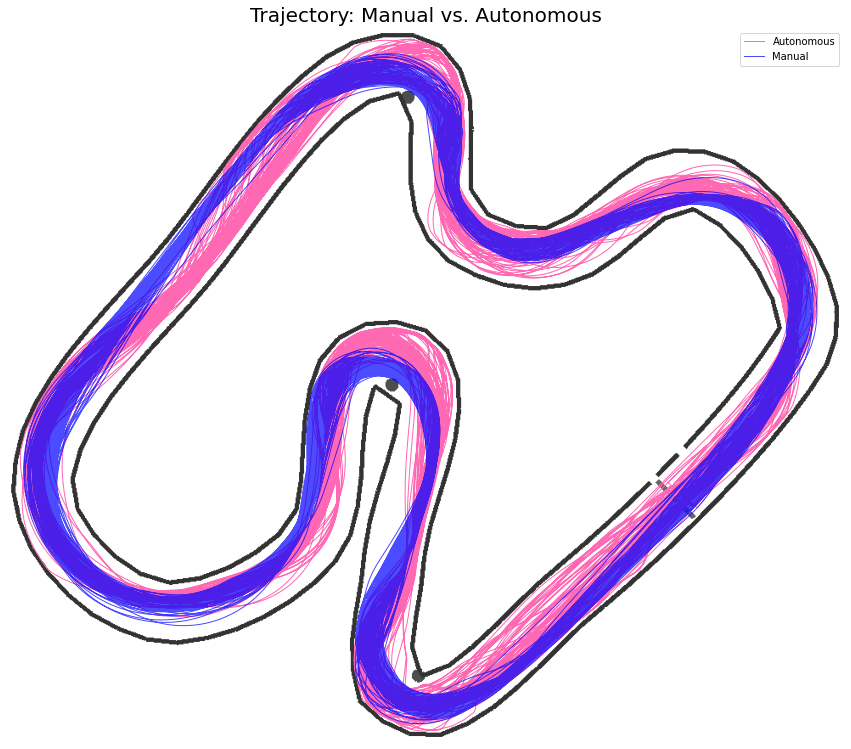

In [8]:
x1, y1 = get_x_y(df_train, train=True)
df = get_trial_laps()
x2 = df['scaled_x']
y2 = df['scaled_z']
img = Image.open(img_file).copy()
img = img.transpose(method=Image.FLIP_TOP_BOTTOM)
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(img)
ax.invert_yaxis()
plot_track(x2, y2, ax, color='hotpink', alpha=1.0)
plot_track(x1, y1, ax, title='Trajectory: Manual vs. Autonomous', color='blue', alpha=0.7)
ax.legend(['Autonomous', 'Manual'])

*Analysis*:
* Overlaying the manual and autonomous trajectories clearly illustrates the differences; the models carried too much speed into turns, casuing wide tracks and collisions, and out of turns, as seen by the trajectories that hug the insde walls of straights despite no manual laps being recorded there. Whereas the steering might have been the same at that point, the higher velocity carried that car further around the curve.

### Colormapped Manual Trajectories (Speed)

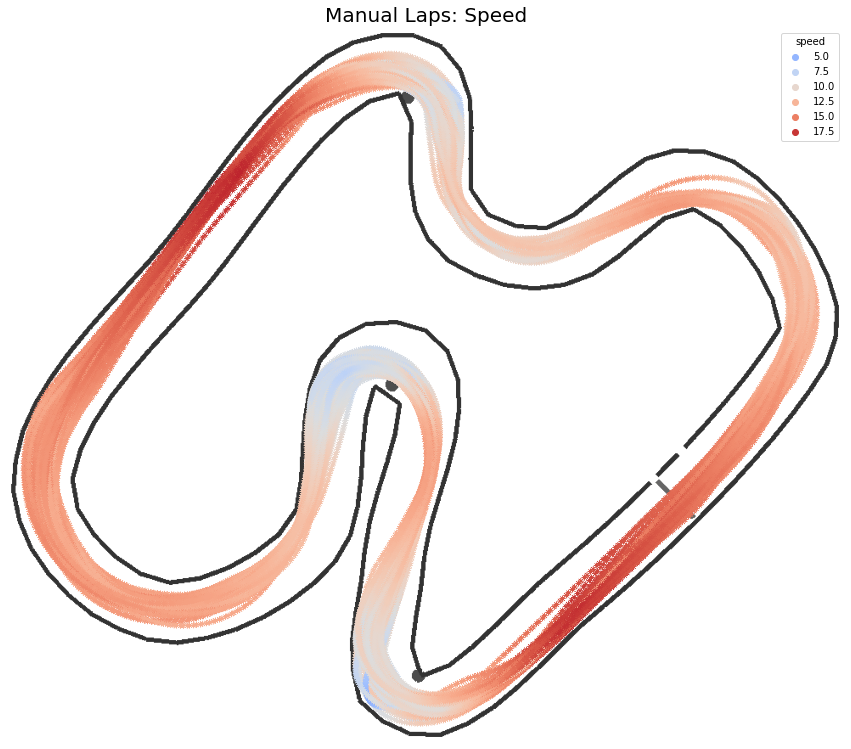

In [9]:
x1, y1 = get_x_y(df_train, train=True)
df = get_trial_laps()
x2 = df['scaled_x']
y2 = df['scaled_z']
fig, ax = plt.subplots(figsize=(15,16))
img = Image.open(img_file).copy()
img = img.transpose(method=Image.FLIP_TOP_BOTTOM)
ax.imshow(img)
ax.invert_yaxis()
ax.axis('off')
plt.title('Manual Laps: Speed', size=20)
ax = sns.scatterplot(data=df_train, 
                     y=y1, 
                     x=x1, 
                     hue='speed', 
                     hue_norm=(0,18.5), 
                     palette='coolwarm', 
                     ax=ax, marker=(8,2,0), 
                     alpha=1.0)

*Analysis*:
* The highest speeds, unsurprisingly, occur at the ends of the longest straight segments.

### Colormapped Autonomous Trajectories (Speed)

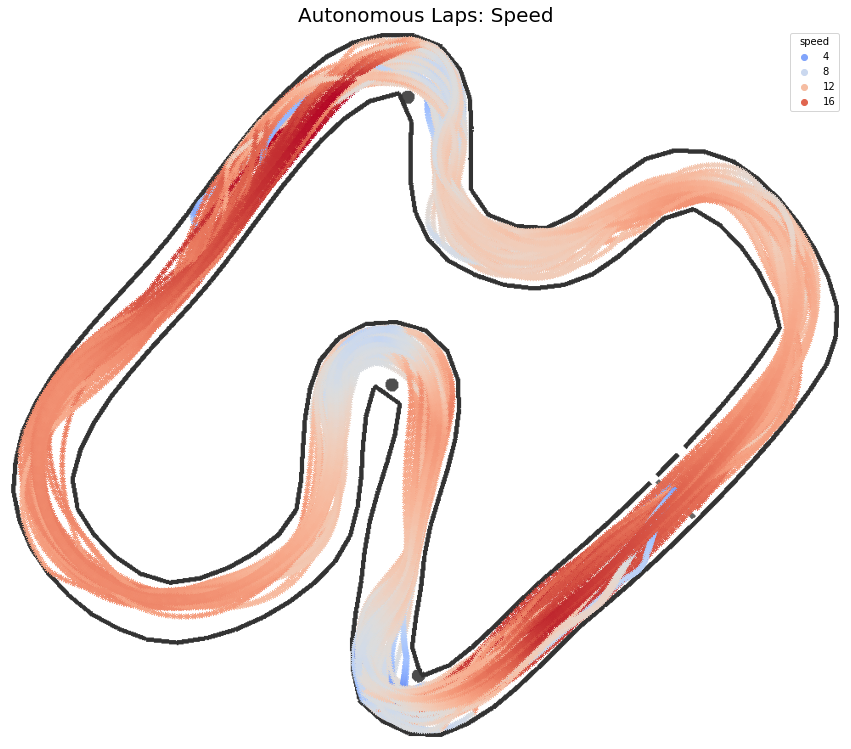

In [10]:
x1, y1 = get_x_y(df_train, train=True)
df = get_trial_laps()
x2 = df['scaled_x']
y2 = df['scaled_z']
fig, ax = plt.subplots(figsize=(15,16))
img = Image.open(img_file).copy()
img = img.transpose(method=Image.FLIP_TOP_BOTTOM)
ax.imshow(img)
ax.invert_yaxis()
ax.axis('off')
plt.title('Autonomous Laps: Speed', size=20)
ax = sns.scatterplot(data=df, 
                     y=y2, 
                     x=x2, 
                     ax=ax, 
                     hue='speed',  
                     hue_norm=(0,18.5),  
                     palette='coolwarm', 
                     marker=(8,2,0), 
                     alpha=1.0)

*Analysis*:
* While superficially similar to the manual data, the autonomous models clearly carried more speed going into the corners.
* As a result, either from overshooting or from crashing, the models were also slower out of turns.

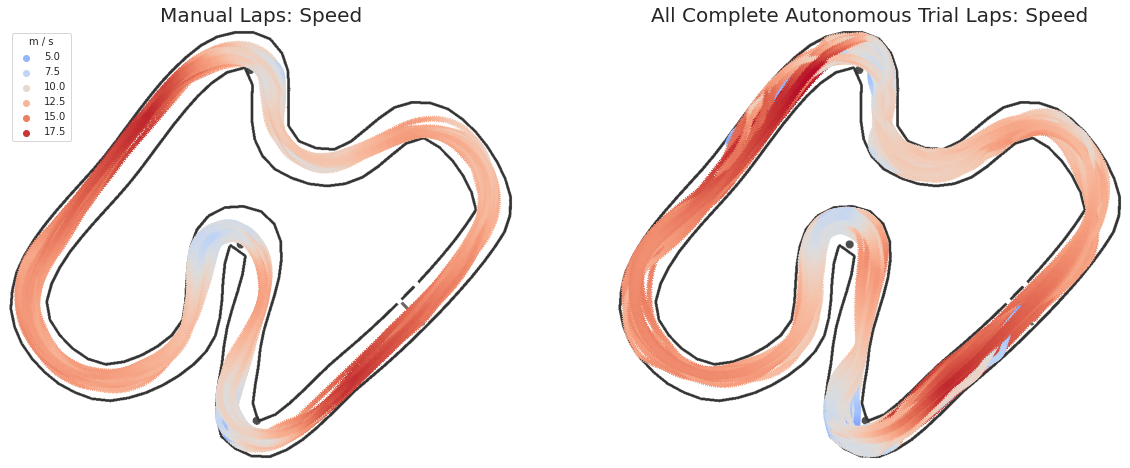

In [42]:
sns.set_style('white')

df = get_trial_laps()
x2 = df['scaled_x']
y2 = df['scaled_z']
z = df['speed'].values

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

img = Image.open(img_file).copy()
img = img.transpose(method=Image.FLIP_TOP_BOTTOM)

ax[1].imshow(img)
ax[1].invert_yaxis()
ax[1].axis('off')
ax[1].set_title('All Complete Autonomous Trial Laps: Speed', size=20)
ax[1] = sns.scatterplot(data=df, 
                         y=y2, 
                         x=x2, 
                         ax=ax[1], 
                         hue='speed',  
                         hue_norm=(0,18.5),  
                         palette='coolwarm', 
                         marker=(8,2,0), 
                         alpha=1.0,
                       legend=False)

x1, y1 = get_x_y(df_train, train=True)
ax[0].imshow(img)
ax[0].invert_yaxis()
ax[0].axis('off')
ax[0].set_title('Manual Laps: Speed', size=20)
ax[0] = sns.scatterplot(data=df_train, 
                         y=y1, 
                         x=x1, 
                         ax=ax[0], 
                         hue='speed',  
                         hue_norm=(0,18.5),  
                         palette='coolwarm', 
                         marker=(8,2,0), 
                         alpha=1.0,)
                        # legend=False)
ax[0].legend(title='m / s');
# plt.tight_layout()

### Colormapped Manual Trajectories (Throttle)

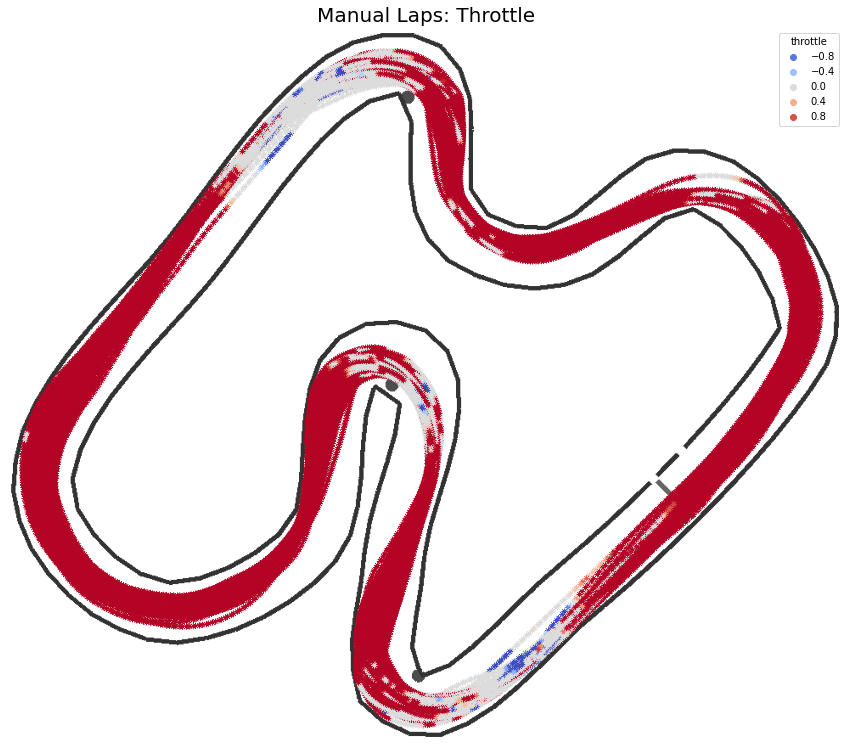

In [ ]:

x1, y1 = get_x_y(df_train, train=True)

df = get_trial_laps()

x2 = df['scaled_x']
y2 = df['scaled_z']
fig, ax = plt.subplots(figsize=(15,16))
img = Image.open(img_file).copy()
img = img.transpose(method=Image.FLIP_TOP_BOTTOM)
ax.imshow(img)
ax.invert_yaxis()
ax.axis('off')
plt.title('Manual Laps: Throttle', size=20)
ax = sns.scatterplot(data=df_train, 
                     y=y1, 
                     x=x1, 
                     hue='throttle', 
                     hue_norm=(-1,1), 
                     palette='coolwarm', 
                     ax=ax, 
                     marker=(8,2,0), 
                     alpha=1.0)

*Analysis*:
* This provides a hint as to why the models drive too fast; I spend most of the time at wide-open throttle (darket red).
* The ideal strategy would have been to stay on the throttle longer than I did, then brake instead of coast.

### Colormapped Autonomous Trajectories (Throttle)

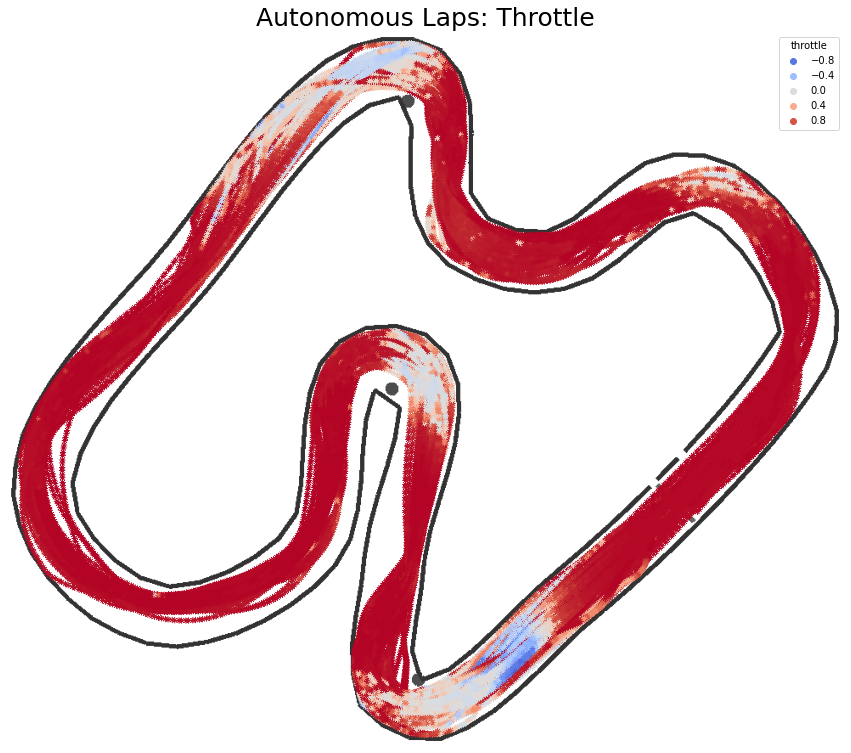

In [ ]:
x1, y1 = get_x_y(df_train, train=True)
df = get_trial_laps()
x2 = df['scaled_x']
y2 = df['scaled_z']
fig, ax = plt.subplots(figsize=(15,16))
img = Image.open(img_file).copy()
img = img.transpose(method=Image.FLIP_TOP_BOTTOM)
ax.imshow(img)
ax.invert_yaxis()
ax.axis('off')
plt.title('Autonomous Laps: Throttle', size=25)
ax = sns.scatterplot(data=df, 
                     y=y2, 
                     x=x2, 
                     ax=ax, 
                     hue='throttle',  
                     hue_norm=(-1,1),  
                     palette='coolwarm', 
                     marker=(8,2,0), 
                     alpha=1.0)

*Analysis*:
* The autonomous throttle inputs were surpisingly close to the manual driving data, but the models clearly let off the throttle too late to make turns.
* Some of the models tried braking (blue). It wasn't enough.

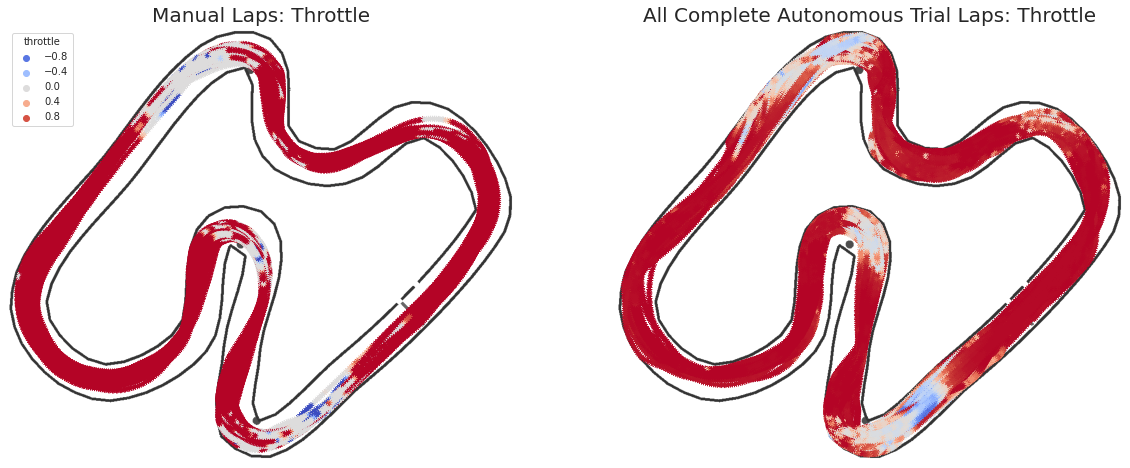

In [38]:
sns.set_style('white')

df = get_trial_laps()
x2 = df['scaled_x']
y2 = df['scaled_z']
z = df['speed'].values

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

img = Image.open(img_file).copy()
img = img.transpose(method=Image.FLIP_TOP_BOTTOM)

ax[1].imshow(img)
ax[1].invert_yaxis()
ax[1].axis('off')
ax[1].set_title('All Complete Autonomous Trial Laps: Throttle', size=20)
ax[1] = sns.scatterplot(data=df, 
                         y=y2, 
                         x=x2, 
                         ax=ax[1], 
                         hue='throttle',  
                         hue_norm=(-1.0,1.0),  
                         palette='coolwarm', 
                         marker=(8,2,0), 
                         alpha=1.0,
                       legend=False)

x1, y1 = get_x_y(df_train, train=True)
ax[0].imshow(img)
ax[0].invert_yaxis()
ax[0].axis('off')
ax[0].set_title('Manual Laps: Throttle', size=20)
ax[0] = sns.scatterplot(data=df_train, 
                         y=y1, 
                         x=x1, 
                         ax=ax[0], 
                         hue='throttle',  
                         hue_norm=(-1.0,1.0),  
                         palette='coolwarm', 
                         marker=(8,2,0), 
                         alpha=1.0,)
                        # legend=False)
# ax[0].marker
# ax[1].legend([-1.0, -0.5, 0.0, 0.5, 1.0]);
# plt.tight_layout()